## Customer Segmentation

The customers are segmented into 3 categories Silver, Gold and Platinum based on the 
Recency - How recently the customer made a purchase
Frequency - How frequently the customer is making the purchase
Monetary Value - How much revenue the user is generating

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# import libraries
from datetime import datetime, timedelta
%matplotlib inline
import matplotlib.pyplot as plt
#from __future__ import division

#import plotly.plotly as py
#import plotly.offline as pyoff
#import plotly.graph_objs as go

#inititate Plotly
#pyoff.init_notebook_mode()

In [126]:
df = pd.read_csv('C:/Users/harini/Desktop/NEUCourses/ADM/Project/e_commerce_synthetic_data.csv')

In [127]:
df.columns

Index(['user_id', 'product_id', 'ratings', 'Unnamed: 0', 'user_session',
       'campaign', 'promotion', 'channel', 'discount', 'Street Address',
       'City', 'State', 'ZipCode', 'event_time', 'event_type', 'category_id',
       'category_code', 'brand', 'price', 'selling_price'],
      dtype='object')

In [128]:
df = df.drop(['Unnamed: 0'],axis =1)

In [129]:
df[df['event_type'] == 'purchase']['selling_price'].mean()

4.816527274001879

In [95]:
idx = df.groupby(['user_id','product_id'])['event_time'].transform(max) == df['event_time']

In [96]:
df1 = df[idx][['user_id','product_id','campaign','promotion','event_type']]

In [97]:
df.price.describe()

count    1.193275e+07
mean     9.469737e+00
std      2.150771e+01
min      0.000000e+00
25%      2.210000e+00
50%      4.110000e+00
75%      7.140000e+00
max      3.277800e+02
Name: price, dtype: float64

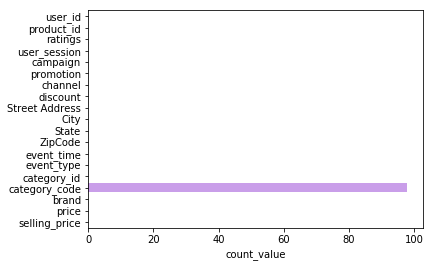

In [7]:
null_values = pd.DataFrame(100*(df.isnull().sum()/len(df)),columns=['count_value'])
ax = sns.barplot(null_values.count_value,null_values.index)

In [74]:
# df = df.drop(['category_code'],axis =1)

In [48]:
df_purchased = df[df.event_type == 'purchase'].reset_index(drop = True)

In [49]:
df_purchased.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737314 entries, 0 to 737313
Data columns (total 19 columns):
user_id           737314 non-null int64
product_id        737314 non-null int64
ratings           737314 non-null int64
user_session      737314 non-null object
campaign          737314 non-null object
promotion         737314 non-null object
channel           737314 non-null object
discount          737314 non-null int64
Street Address    737314 non-null object
City              737314 non-null object
State             737314 non-null object
ZipCode           737314 non-null int64
event_time        737314 non-null object
event_type        737314 non-null object
category_id       737314 non-null int64
category_code     13847 non-null object
brand             737314 non-null object
price             737314 non-null float64
selling_price     737314 non-null float64
dtypes: float64(2), int64(6), object(11)
memory usage: 106.9+ MB


In [50]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
df_users_purchased = pd.DataFrame(df_purchased['user_id'].unique())

In [51]:
df_users_purchased.columns = ['user_id']

In [52]:
len(df_users_purchased)

98458

In [53]:
recency_df = df_purchased.groupby('user_id').event_time.max().reset_index()
recency_df.columns = ['user_id','LastPurchaseDate']

In [54]:
len(recency_df)

98458

In [55]:
recency_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98458 entries, 0 to 98457
Data columns (total 2 columns):
user_id             98458 non-null int64
LastPurchaseDate    98458 non-null object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [56]:
recency_df['LastPurchaseDate'] = pd.to_datetime(recency_df['LastPurchaseDate'])

In [57]:
recency_df['LastPurchaseDate'] = recency_df['LastPurchaseDate'].dt.tz_localize(None)

In [58]:
recency_df['LastPurchaseDate'].max()

Timestamp('2020-02-29 23:54:44')

In [59]:
import datetime as dt
# import timezones
# from datetime import datetime, timezone

now = datetime(2020, 3, 1, 0, 0, 0)

In [60]:
recency_df['Recency'] = recency_df.LastPurchaseDate.apply(lambda x : (now - x).days)

In [61]:
recency_df.head()

,user_id,LastPurchaseDate,Recency
0,9794320,2019-11-25 05:07:13,96
1,10079204,2019-11-06 10:43:30,115
2,10280338,2020-02-19 15:21:31,10
3,12055855,2019-12-20 12:05:29,71
4,12936739,2020-01-17 07:51:19,43


In [62]:
len(recency_df.user_id)

98458

In [63]:
df_purchased['event_time'] = pd.to_datetime(df_purchased['event_time'])

In [64]:
df_purchased['event_time'] = df_purchased['event_time'].dt.tz_localize(None)

In [65]:
#check frequency of customer means how many transaction has been done..

frequency_df = df_purchased.copy()
frequency_df.drop_duplicates(subset=['user_id','event_time'], keep="first", inplace=True) 
frequency_df = frequency_df.groupby('user_id',as_index=False)['event_time'].count()
frequency_df.columns = ['user_id','Frequency']
frequency_df.head()

,user_id,Frequency
0,9794320,1
1,10079204,1
2,10280338,5
3,12055855,1
4,12936739,1


In [28]:
len(frequency_df.user_id.unique())

98458

In [66]:
monetary_df=df_purchased.groupby(['user_id'],as_index=False)['selling_price'].sum()
monetary_df.columns = ['user_id','Monetary']

In [67]:
monetary_df.Monetary.describe()

count    98458.000000
mean        36.069116
std         56.513231
min          0.051000
25%          9.639000
50%         19.411500
75%         40.180000
max       2357.095000
Name: Monetary, dtype: float64

In [68]:
#Combine all together all dataframe in so we have recency, frequency and monetary values together..

#combine first recency and frequency.
rf = recency_df.merge(frequency_df,on='user_id')

#combibe rf frame with monetary values.

rfm = rf.merge(monetary_df,left_on='user_id',right_on='user_id')

rfm.set_index('user_id',inplace=True)

rfm.head()

,LastPurchaseDate,Recency,Frequency,Monetary
user_id,,,,
9794320,2019-11-25 05:07:13,96,1,10.778
10079204,2019-11-06 10:43:30,115,1,20.648
10280338,2020-02-19 15:21:31,10,5,62.616
12055855,2019-12-20 12:05:29,71,1,16.540
12936739,2020-01-17 07:51:19,43,1,26.970


In [69]:
rfm = rfm.drop(['LastPurchaseDate'], axis=1)

In [70]:
rfm_segmentation = rfm.copy()

In [71]:
rfm_segmentation.head()

,Recency,Frequency,Monetary
user_id,,,
9794320,96,1,10.778
10079204,115,1,20.648
10280338,10,5,62.616
12055855,71,1,16.540
12936739,43,1,26.970


We are going to apply K-means clustering to assign a recency score. But we should tell how many clusters we need to K-means algorithm. To find it out, we will apply Elbow Method. Elbow Method simply tells the optimal cluster number for optimal inertia

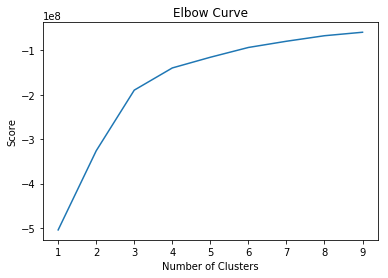

In [72]:
from sklearn.cluster import KMeans
# get right number of cluster for K-means so we neeed to loop from 1 to 20 number of cluster and check score.
#Elbow method is used to represnt that. 
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(rfm_segmentation).score(rfm_segmentation) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [74]:
#fitting data in Kmeans theorem.
kmeans = KMeans(n_clusters=3, random_state=0).fit(rfm_segmentation)

In [75]:
# this creates a new column called cluster which has cluster number for each row respectively.
rfm_segmentation['cluster'] = kmeans.labels_

In [76]:
#check our hypothesis

rfm_segmentation.cluster.value_counts()

1    48167
0    45833
2     4458
Name: cluster, dtype: int64

In [77]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,cluster
user_id,,,,
9794320,96,1,10.778,1
10079204,115,1,20.648,1
10280338,10,5,62.616,0
12055855,71,1,16.540,1
12936739,43,1,26.970,0


In [78]:
rfm_segmentation = rfm_segmentation.reset_index()

In [79]:
rfm_segmentation.head()

,user_id,Recency,Frequency,Monetary,cluster
0,9794320,96,1,10.778,1
1,10079204,115,1,20.648,1
2,10280338,10,5,62.616,0
3,12055855,71,1,16.540,1
4,12936739,43,1,26.970,0


In [80]:
rfm_segmentation_users = pd.DataFrame(rfm_segmentation.user_id)
rfm_segmentation_users.head()

,user_id
0,9794320
1,10079204
2,10280338
3,12055855
4,12936739


In [81]:
rfm_segmentation = rfm_segmentation.drop(['user_id'],axis =1)
rfm_segmentation.head()

,Recency,Frequency,Monetary,cluster
0,96,1,10.778,1
1,115,1,20.648,1
2,10,5,62.616,0
3,71,1,16.540,1
4,43,1,26.970,0


In [413]:
rfm_segmentation['Status'] = rfm_segmentation['cluster'].apply(lambda x : 'Silver' if x == 0 
                                                              else 'Gold' if x == 1
                                                              else 'Platinum')

In [415]:
rfm_segmentation.Status.value_counts()

Gold        48167
Silver      45833
Platinum     4458
Name: Status, dtype: int64

In [82]:
rfm_segmentation = pd.merge(rfm_segmentation_users,rfm_segmentation, left_index=True, right_index=True)

In [83]:
rfm_segmentation.head()

,user_id,Recency,Frequency,Monetary,cluster
0,9794320,96,1,10.778,1
1,10079204,115,1,20.648,1
2,10280338,10,5,62.616,0
3,12055855,71,1,16.540,1
4,12936739,43,1,26.970,0


In [84]:
del  df_purchased,df_users_purchased, recency_df, frequency_df, monetary_df, rf, rfm

In [329]:
df = pd.merge(df1, rfm_segmentation, on = 'user_id')

In [330]:
df.head()

,user_id,product_id,campaign,promotion,event_type,Recency,Frequency,Monetary,cluster
0,576802932,5712790,Social Media,Discount,remove_from_cart,90,1,106.01,1
1,576802932,5650294,Social Media,Discount,remove_from_cart,90,1,106.01,1
2,576802932,5692261,Social Media,Discount,remove_from_cart,90,1,106.01,1
3,576802932,5694628,Social Media,Discount,remove_from_cart,90,1,106.01,1
4,576802932,5817779,Social Media,Discount,remove_from_cart,90,1,106.01,1


In [383]:
data = df.drop(['cluster','Frequency'], axis = 1)

In [384]:
data.head()

,user_id,product_id,campaign,promotion,event_type,Recency,Monetary
0,576802932,5712790,Social Media,Discount,remove_from_cart,90,106.01
1,576802932,5650294,Social Media,Discount,remove_from_cart,90,106.01
2,576802932,5692261,Social Media,Discount,remove_from_cart,90,106.01
3,576802932,5694628,Social Media,Discount,remove_from_cart,90,106.01
4,576802932,5817779,Social Media,Discount,remove_from_cart,90,106.01


## Uplift Modeling

The uplift model help in targeting promotion to customers who are most like to respond which will help increase the conversion rate with less promotional costs.

We have used 4 Quadrant Uplift model to calculate the uplift score for each user

In [103]:
data.event_type.unique()

array(['remove_from_cart', 'purchase', 'view', 'cart'], dtype=object)

In [107]:
data.campaign.unique()

array(['Social Media', 'Referal', 'E-mail', 'Web Search'], dtype=object)

In [135]:
data.promotion.unique()

array(['Discount', 'Buy One Get One', 'Free Sample', 'No Promotion'],
      dtype=object)

In [385]:
data['conversion'] = data['event_type'].apply(lambda x : 1 if x == 'purchase' else 0)

In [386]:
data['used_discount'] = data['promotion'].apply(lambda x: 1 if x == 'Discount' else 0)
data['used_bogo'] = data['promotion'].apply(lambda x: 1 if x == 'Buy One Get One' else 0)
data['used_free_sample'] = data['promotion'].apply(lambda x: 1 if x == 'Free Sample' else 0)

In [387]:
data = data.drop(['event_type'], axis = 1)

In [388]:
data.conversion.mean()

0.22734837140904757

In [277]:
def calc_uplift(df):
    avg_order_value = 5
    
    #calculate conversions for each offer type
    base_conv = df[df.promotion == 'No Promotion']['conversion'].mean()
    disc_conv = df[df.promotion == 'Discount']['conversion'].mean()
    bogo_conv = df[df.promotion == 'Buy One Get One']['conversion'].mean()
    fs_conv = df[df.promotion == 'Free Sample']['conversion'].mean()
    
    #calculate conversion uplift for discount and bogo
    disc_conv_uplift = disc_conv - base_conv
    bogo_conv_uplift = bogo_conv - base_conv
    fs_conv_uplift = fs_conv - base_conv
    
    #calculate order uplift
    disc_order_uplift = disc_conv_uplift * len(df[df.promotion == 'Discount']['conversion'])
    bogo_order_uplift = bogo_conv_uplift * len(df[df.promotion == 'Buy One Get One']['conversion'])
    fs_order_uplift = fs_conv_uplift * len(df[df.promotion == 'Free Sample']['conversion'])
    
    #calculate revenue uplift
    disc_rev_uplift = disc_order_uplift * avg_order_value
    bogo_rev_uplift = bogo_order_uplift * avg_order_value
    fs_rev_uplift = fs_order_uplift * avg_order_value
    
    
    print('Discount Conversion Uplift: {0}%'.format(np.round(disc_conv_uplift*100,2)))
    print('Discount Order Uplift: {0}'.format(np.round(disc_order_uplift,2)))
    print('Discount Revenue Uplift: ${0}\n'.format(np.round(disc_rev_uplift,2)))
    
    if len(df[df.promotion == 'Buy One Get One']['conversion']) > 0:
          
        print('-------------- \n')
        print('BOGO Conversion Uplift: {0}%'.format(np.round(bogo_conv_uplift*100,2)))
        print('BOGO Order Uplift: {0}'.format(np.round(bogo_order_uplift,2)))
        print('BOGO Revenue Uplift: ${0}'.format(np.round(bogo_rev_uplift,2)))
        
    if len(df[df.promotion == 'Free Sample']['conversion']) > 0:
          
        print('-------------- \n')
        print('FS Conversion Uplift: {0}%'.format(np.round(fs_conv_uplift*100,2)))
        print('FS Order Uplift: {0}'.format(np.round(fs_order_uplift,2)))
        print('FS Revenue Uplift: ${0}'.format(np.round(fs_rev_uplift,2)))
        

In [278]:
calc_uplift(data)

Discount Conversion Uplift: 0.09%
Discount Order Uplift: 1103.08
Discount Revenue Uplift: $5515.38

-------------- 

BOGO Conversion Uplift: 0.01%
BOGO Order Uplift: 58.52
BOGO Revenue Uplift: $292.62
-------------- 

FS Conversion Uplift: 0.27%
FS Order Uplift: 604.16
FS Revenue Uplift: $3020.82


In [389]:
#Creating Column campgaign_group for dividing control and treatment groups
data['campaign_group'] = 'treatment'
data.loc[data.promotion == 'No Promotion', 'campaign_group'] = 'control'

In [390]:
#Control Non-Responders
data['target_class'] = 0

#Control Responders
data.loc[(data.campaign_group == 'control') & (data.conversion > 0),'target_class'] = 1

#Treatment Non-Responders
data.loc[(data.campaign_group == 'treatment') & (data.conversion == 0),'target_class'] = 2

#Treatment Responders
data.loc[(data.campaign_group == 'treatment') & (data.conversion > 0),'target_class'] = 3

In [340]:
data.target_class.value_counts()

2    1685823
0     500965
3     496567
1     146883
Name: target_class, dtype: int64

In [341]:
data.target_class.value_counts()/len(data)

2    0.595647
0    0.177005
3    0.175451
1    0.051898
Name: target_class, dtype: float64

In [391]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(data[['Monetary']])
data['Monetary_cluster'] = kmeans.predict(data[['Monetary']])

In [392]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [393]:
data = order_cluster('Monetary_cluster', 'Monetary',data,True)

In [394]:
data.head()

,user_id,product_id,campaign,promotion,Recency,Monetary,conversion,used_discount,used_bogo,used_free_sample,campaign_group,target_class,Monetary_cluster
0,576802932,5712790,Social Media,Discount,90,106.01,0,1,0,0,treatment,2,1
1,576802932,5650294,Social Media,Discount,90,106.01,0,1,0,0,treatment,2,1
2,576802932,5692261,Social Media,Discount,90,106.01,0,1,0,0,treatment,2,1
3,576802932,5694628,Social Media,Discount,90,106.01,0,1,0,0,treatment,2,1
4,576802932,5817779,Social Media,Discount,90,106.01,0,1,0,0,treatment,2,1


In [395]:
df_model = data.drop(['promotion','campaign_group','conversion'],axis=1)
df_model = pd.get_dummies(df_model)

In [396]:
df_model.head()

,user_id,product_id,Recency,Monetary,used_discount,used_bogo,used_free_sample,target_class,Monetary_cluster,campaign_E-mail,campaign_Referal,campaign_Social Media,campaign_Web Search
0,576802932,5712790,90,106.01,1,0,0,2,1,0,0,1,0
1,576802932,5650294,90,106.01,1,0,0,2,1,0,0,1,0
2,576802932,5692261,90,106.01,1,0,0,2,1,0,0,1,0
3,576802932,5694628,90,106.01,1,0,0,2,1,0,0,1,0
4,576802932,5817779,90,106.01,1,0,0,2,1,0,0,1,0


In [349]:
#create feature set and labels
X = df_model.drop(['target_class'],axis=1)
y = df_model.target_class

In [398]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.45, random_state=56)

In [362]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)

In [399]:
class_probs = xgb_model.predict_proba(X_test)
class_probs[0]

array([0.00108893, 0.00116519, 0.7845392 , 0.21320663], dtype=float32)

For this specific customer, we can map the probabilities as below:

CN: 84%
CR: 15.8%
TN: 0.1%
TR: 0.1%
So the uplift score for this customer is:

Uplift Score = CN + TR - TN - CR 

0.84 + 0.001- 0.001- 0.15.8 = 0.68

Let’s apply this to all users and calculate the uplift score:

In [400]:
X_test['proba_CN'] = class_probs[:,0] 
X_test['proba_CR'] = class_probs[:,1] 
X_test['proba_TN'] = class_probs[:,2] 
X_test['proba_TR'] = class_probs[:,3]

In [401]:
X_test['uplift_score'] = X_test.eval('proba_CN + proba_TR - proba_TN - proba_CR')

In [402]:
X_test.head()

,user_id,product_id,Recency,Monetary,used_discount,used_bogo,used_free_sample,Monetary_cluster,campaign_E-mail,campaign_Referal,campaign_Social Media,campaign_Web Search,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score
1454130,589264541,5815789,68,4.7160,0,1,0,0,0,0,1,0,0.001089,0.001165,0.784539,0.213207,-0.571409
423163,480237908,5884341,118,169.2695,0,0,1,1,1,0,0,0,0.003611,0.003931,0.761018,0.231440,-0.529899
2151666,558779782,5686807,138,43.7300,0,0,0,0,1,0,0,0,0.743983,0.230046,0.009862,0.016109,0.520183
1497469,513141520,5696173,70,26.1375,1,0,0,0,0,0,1,0,0.000939,0.000939,0.793003,0.205119,-0.587884
2059037,510658105,5808554,132,43.9600,0,0,0,0,0,0,1,0,0.774876,0.201871,0.010248,0.013006,0.575763


In [403]:
#probabilities for all customers
overall_proba = xgb_model.predict_proba(df_model.drop(['target_class'],axis=1))

In [404]:
#assign probabilities to 4 different columns
df_model['proba_CN'] = overall_proba[:,0] 
df_model['proba_CR'] = overall_proba[:,1] 
df_model['proba_TN'] = overall_proba[:,2] 
df_model['proba_TR'] = overall_proba[:,3]

In [405]:
#calculate uplift score for all customers
df_model['uplift_score'] = df_model.eval('proba_CN + proba_TR - proba_TN - proba_CR')

In [406]:
#assign it back to main dataframe
data['uplift_score'] = df_model['uplift_score']

Mean Uplift Scores for both offers and non offer

In [407]:
data.groupby('promotion').uplift_score.mean()

promotion
Buy One Get One   -0.549524
Discount          -0.546900
Free Sample       -0.546554
No Promotion       0.549302
Name: uplift_score, dtype: float32

#### Model Evaluation

To evaluate our model, we will create two different groups and compare them with our benchmark. Groups are:

1- High Uplift Score: Customers have uplift score > 3rd quantile

2- Low Uplift Score: Customers have uplift score < 2nd quantile

In [408]:
df_data_lift = data.copy()
uplift_q_75 = df_data_lift.uplift_score.quantile(0.75)
df_data_lift = df_data_lift[(df_data_lift.uplift_score > uplift_q_75)].reset_index(drop=True)

In [409]:
data.uplift_score.quantile(0.75)

-0.279233455657959

In [410]:
calc_uplift(df_data_lift)

Discount Conversion Uplift: 25.42%
Discount Order Uplift: 9572.14
Discount Revenue Uplift: $47860.72

-------------- 

BOGO Conversion Uplift: 28.73%
BOGO Order Uplift: 5808.76
BOGO Revenue Uplift: $29043.82
-------------- 

FS Conversion Uplift: 41.63%
FS Order Uplift: 763.96
FS Revenue Uplift: $3819.8


In [376]:
df_data_lift = data.copy()
uplift_q_5 = df_data_lift.uplift_score.quantile(0.5)
df_data_lift = df_data_lift[(df_data_lift.uplift_score > uplift_q_5)].reset_index(drop=True)

In [377]:
data.uplift_score.quantile(0.5)

-0.515627384185791

In [378]:
calc_uplift(df_data_lift)

Discount Conversion Uplift: 9.44%
Discount Order Uplift: 38989.23
Discount Revenue Uplift: $194946.14

-------------- 

BOGO Conversion Uplift: 9.73%
BOGO Order Uplift: 26732.9
BOGO Revenue Uplift: $133664.49
-------------- 

FS Conversion Uplift: 10.65%
FS Order Uplift: 8454.29
FS Revenue Uplift: $42271.46


In [411]:
data.head()

,user_id,product_id,campaign,promotion,Recency,Monetary,conversion,used_discount,used_bogo,used_free_sample,campaign_group,target_class,Monetary_cluster,uplift_score
0,576802932,5712790,Social Media,Discount,90,106.01,0,1,0,0,treatment,2,1,-0.291733
1,576802932,5650294,Social Media,Discount,90,106.01,0,1,0,0,treatment,2,1,-0.281304
2,576802932,5692261,Social Media,Discount,90,106.01,0,1,0,0,treatment,2,1,-0.281304
3,576802932,5694628,Social Media,Discount,90,106.01,0,1,0,0,treatment,2,1,-0.281304
4,576802932,5817779,Social Media,Discount,90,106.01,0,1,0,0,treatment,2,1,-0.297483


In [416]:
data.columns

Index(['user_id', 'product_id', 'campaign', 'promotion', 'Recency', 'Monetary',
       'conversion', 'used_discount', 'used_bogo', 'used_free_sample',
       'campaign_group', 'target_class', 'Monetary_cluster', 'uplift_score'],
      dtype='object')

In [417]:
data_1 = data.drop(['Recency', 'Monetary','used_discount', 'used_bogo', 'used_free_sample'], axis = 1)

In [419]:
final_data = pd.merge(data_1,rfm_segmentation , on  ='user_id')

In [12]:
final_data.to_csv('C:/Users/harini/Desktop/NEUCourses/ADM/Project/RFM_Uplift_data.csv', index = False, encoding = 'utf-8')